In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## Introduction

***

In what follows, I will analyze the [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) containing relevant information about ~5k patients. The aim of this study is to check whether, given a set of features describing the health status of the patient, it is possible to predict a stroke event.   

The complete list of attributes includes 12 features which are listed below:

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not

***

## Index

The notebook has been structured as follows:

1. [Read the dataset and get familiar with the data](#1.-Read-the-dataset-and-get-familiar-with-the-data)
    1. [Feature engineering](#1.A-Feature-engineering)
2. [Data visualization](#2.-Data-visualization)
    1. [Distributions](#2.1-Distributions)
    2. [Study of the correlation matrix](#2.2-Study-of-the-correlation-matrix)
3. [Testing resampling techniques with XGBoost binary classifier](#3.-Testing-resampling-techniques-with-XGBoost-binary-classifier)
    1. [Hyperparameters tuning with GridSearchCV](#3.1-Hyperparameters-tuning-with-GridSearchCV)
4. [Dimensionality reduction](#4.-Dimensionality-reduction)
    1. [Univariate analysis](#4.A-Univariate-analysis)
    2. <a href="#4.B-Recursive-feature-elimination-(RFE)-with-random-forestt">Recursive feature elimination (RFE) with random forest</a>
    3. <a href="#4.C-RFE-with-Cross-Validation-(RFECV)-with-random-forest">RFE with Cross Validation (RFECV) with xgboost</a>
    4. <a href="#4.D-Principle-component-analysis-(PCA)-for-feature-extraction">Principle component analysis (PCA) for feature extraction</a>

## 1. Read the dataset and get familiar with the data
### 1.A Feature engineering
The dataset includes the data for 5110 patients, each one being associated with a unique ID which is not a relevant feature for the analysis presented here. There are 8 categorical features:   `gender`,`hypertension`,`heart_disease`,`ever_married`,`work_type`,`residence_type`,`smoking status`,`stroke`,  
and 3 non-categorical (discrete or continuous) features  
`age`,`avg_glucose_level` and `bmi`.

The `stroke` feature will be the target variable we aim to predict. 

In [3]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
#The gender section can take three different values: 'Male', 'Female' and 'Other'. 
#However, in the next line I check that there is just one patient in the category 'Other'. For this reson, since there is not a sufficiently high number of representatives in this category to perform a statistical analysis, 
#I will drop the corresponding line. Sorry for that :)
df.drop(df[df['gender']=='Other'].index,inplace=True)
df.drop(['id'],axis=1,inplace=True)

In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

There are 201 NaNs values in the bmi field, for this reason I will employ the [nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) imputation provided by the scikit-learn library.

In [6]:
from sklearn.impute import KNNImputer
imp = KNNImputer(missing_values=np.NaN)
df.bmi = imp.fit_transform(df['bmi'].values.reshape(-1,1))[:,0]

Encoding the categorical variables with the [sklearn ordinal encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) for computing the correlation between features. However, given that there is no intrinsic order among the categories in each feature, [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) is more suitable for this task.

Many other algorithms can be tested. In particular, there is [a very interesting package](http://contrib.scikit-learn.org/category_encoders/index.html#) including many encoding algorithms.


In [7]:
categ_feat = ['gender','Residence_type','work_type','ever_married','smoking_status']
encoder = OrdinalEncoder()
result = encoder.fit_transform(df[categ_feat])
df_ordinal = df.copy()
df_ordinal[categ_feat] = result


dummies = pd.get_dummies(df[categ_feat],drop_first=True )
df_tmp = df.drop(categ_feat, axis = 1)
df_one_hot = pd.concat([df_tmp,dummies],axis=1)

In [8]:
df_one_hot.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,Residence_type_Urban,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,ever_married_Yes,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,0,0,0,1,0,1,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,0,0,1,0,0,1,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,0,0,0,1,0,1,0,1,0


In [9]:
# df_cols = df_one_hot.columns

# scaler = MinMaxScaler()
# df_one_hot = pd.DataFrame(scaler.fit_transform(df_one_hot),columns=df_cols)
# df_one_hot.head()

## 2. Data visualization
### 2.1 Distributions
In this section, I will compare the distribution of the variables in the two subsets 'Stroke' and "No Stroke'. If the distribution of a given feature matches in the two sets within statistical uncertainties, then we can conclude that the selected feature is not correlated with the target. The results obtained in this section will be compared in Sec. 4 with the findings of the dimensionality reduction.

Findings:
1. From the plot below it is clear that age is one of the most important features in the dataset, being the distribution among patients who were subjected to stroke shifted towards higher values. In particular, the distribution of the subset 'Stroke' is strongly peaked around 80 years. 
2. **BMI** may have an impact on the probability to be subjected to stroke since the distribution of the subset 'Stroke' shows a smaller variance compared to the 'No Stroke' one.
3. The distributions of the **average glucose level** show similar qualitative behavior in the two datasets. However, among the patients subjected to stroke is more common to have higher glucose levels (i.e. ~200).
4. **Gender** seems not to be a predominant feature here, since no significant differences between the two distributions have been observed.
5. **Hypertension** is a relevant feature, which is statistically more present among patients subjected to stroke.
6. **Heart disease**, like hypertension, can be relevant.
7. The feature **ever_married** shows a correlation with the target 'Stroke'. However, this can be explained from the correlation of this feature with the age, which we know is an important variable in this analysis. 
8. The **work type** shows a correlation with the target, which is however due to the presence of children in the sample. Thus, this feature is expected to be correlated with age.
9. The distributions of the **residence type** show a mild asymmetry between the two datasets. However, this can be due to statistical fluctuations.
10. Finally, the **smoking status** is correlated with the target. Indeed, there are fewer patients with 'unknown' smoking status in the dataset 'Stroke' in favor of the status 'formerly smoked'. 


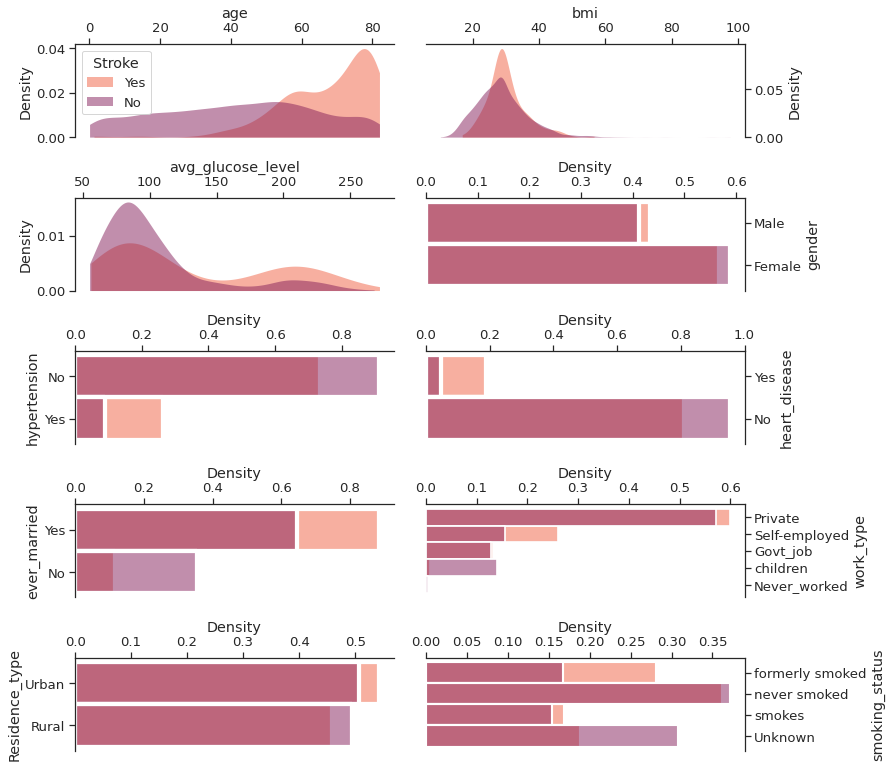

In [10]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
fig = plt.figure(figsize=(12,13))
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.65)
axes = []
for j in range(10):
    axes.append(fig.add_subplot(gs[int(j/2),j%2]))
    
#Feature 1: age
sns.kdeplot(data=df, x="age", hue="stroke",
   fill=True, common_norm=False, palette="rocket",
   alpha=.5, linewidth=0,ax=axes[0],cut=0,legend=False)
axes[0].legend(loc='upper left',title='Stroke', labels = ['Yes','No'])


#Feature 2: bmi
sns.kdeplot(data=df, x="bmi", hue="stroke",
   fill=True, common_norm=False, palette="rocket",
   alpha=.5, linewidth=0,ax=axes[1],legend=False,cut=0)




#Feature 3: bmi
sns.kdeplot(data=df, x="avg_glucose_level", hue="stroke",
   fill=True, common_norm=False, palette="rocket",
   alpha=.5, linewidth=0,ax=axes[2],legend=False,cut=0)


#Feature 4:gender
sns.histplot(y='gender', hue="stroke",
            palette="rocket",
            data=df, ax=axes[3],stat='density',
            common_norm=False,legend=False)

#Feature 5:hypertension
tmp_df = df.copy()
tmp_df['hypertension'] = tmp_df['hypertension'].map(lambda x: {0:'No',1:'Yes'}[x])

sns.histplot(y='hypertension', hue="stroke",
            palette="rocket",
            data=tmp_df, ax=axes[4],stat='density',
            common_norm=False,legend=False)


#Feature 6:heart_disease
tmp_df = df.copy()
tmp_df['heart_disease'] = tmp_df['heart_disease'].map(lambda x: {0:'No',1:'Yes'}[x])

sns.histplot(y='heart_disease', hue="stroke",
            palette="rocket",
            data=tmp_df, ax=axes[5],stat='density',
            common_norm=False,legend=False)

for j,feat in enumerate(['ever_married','work_type','Residence_type','smoking_status']):
    sns.histplot(y=feat, hue="stroke",
            palette="rocket",
            data=df, ax=axes[6+j],stat='density',
            common_norm=False,legend=False)


for j in range(10):
    which_ax = ['bottom','right'] if j%2==0 else ['bottom','left']
    for s in which_ax:
        axes[j].spines[s].set_visible(False)
    if(j%2==1):
        axes[j].yaxis.tick_right()
        axes[j].yaxis.set_label_position("right")
    axes[j].xaxis.tick_top()
    axes[j].xaxis.set_label_position("top")

### 2.2 Study of the correlation matrix
Below I show the correlation matrix between the features. 
* In the first place, the 'stroke' feature is correlated (in reverse order of importance) with age, hypertension, heart disease, average glucose level, marital status, smoking status, work type, BMI, residence type and gender. 
* However, as mentioned in [Sec. 2.1](#2.1-Distributions), the correlation with gender is negligible, as well as the one with the residence type. 
* Among the variables correlated with the target, many of them are strongly correlated with age. In particular the marital status, the work type, the bmi and smoking status have correlation coefficient greater than 0.3 with the age. For this reason it will be important to reduce the number of features.

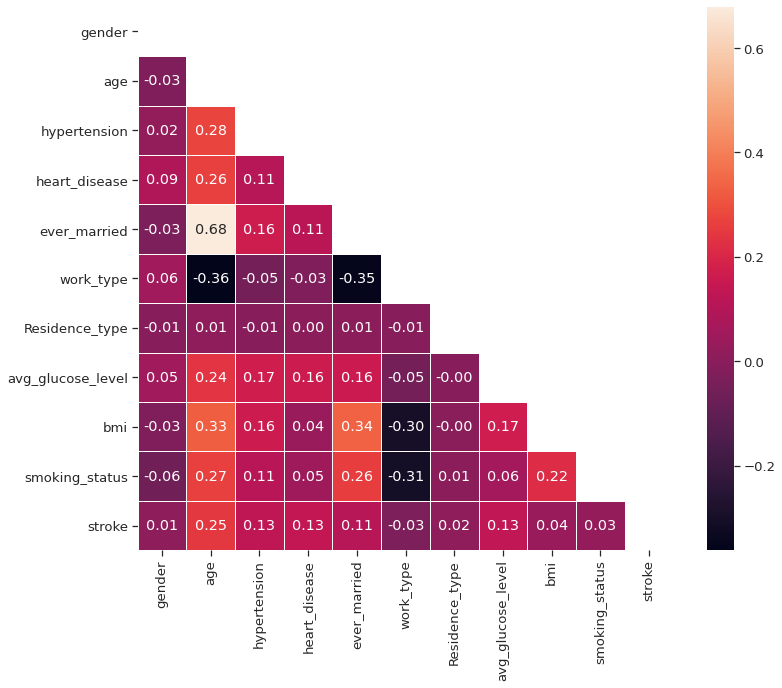

In [11]:
f,ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(df_ordinal.corr(), dtype=bool))
sns.heatmap(df_ordinal.corr(),mask=mask, annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

## 3. Testing resampling techniques with XGBoost binary classifier
The dataset is strongly imbalanced, just 5% of the patients were subjected to a stroke. For this reason, it is necessary to employ a **resampling** technique. All the algorithms employed here to tackle the issue are present in the [imblearn](https://imbalanced-learn.org/stable/) library. 
* In particular, I will employ some oversampling techniques (i.e. *SMOTE, Random oversampling*), one undersampling technique (i.e. Random undersampling) and some mixed algorithms (i.e. *SMOTE + ENN* and *SMOTE + Tomek links*).
* The resampling algorithms will be tested with the XGBoost binary classifier.
* All the resampling techniques will be employed **on the training set only**.

In [12]:
def compute_score(y_train,y_test,y_train_p,y_test_p):
    test_ac = accuracy_score(y_test,y_test_p)
    train_ac = accuracy_score(y_train,y_train_p)
    test_f1 = f1_score(y_test,y_test_p)
    train_f1 = f1_score(y_train,y_train_p)

    cmte = confusion_matrix(y_test,y_test_p)
    
    cmtr = confusion_matrix(y_train,y_train_p)
        
    d = {'Dataset':['Test','Train'],'F1':[test_f1,train_f1]}
    d['Accuracy'] = [test_ac,train_ac]
    d['Recall'] = [recall_score(y_test,y_test_p),recall_score(y_train,y_train_p)]
    d['Precision'] = [precision_score(y_test,y_test_p),precision_score(y_train,y_train_p)]
    d['ROC AUC'] = [roc_auc_score(y_test,y_test_p),roc_auc_score(y_train,y_train_p)]
    d['False Positives (T-I)'] = [cmte[0,1],cmtr[0,1]]
    d['False Negatives (T-II)'] = [cmte[1,0],cmtr[1,0]]
    d['True Positives'] = [cmte[1,1],cmtr[1,1]]
    d['True Negatives'] = [cmte[0,0],cmtr[0,0]]
    
    
    
    display(pd.DataFrame(d).head(2))

In [13]:
def plot_res(results):
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    fig = plt.figure(figsize=(6,4))
    gs = fig.add_gridspec(1, 1)
    gs.update(wspace=0.1, hspace=0.65)
    ax = []
    ax.append(fig.add_subplot(gs[0,0]))
#     ax.append(fig.add_subplot(gs[0,1]))
#     ax[0].plot(x_axis, results['validation_0']['f1'], label='Train',color='red')
#     ax[0].plot(x_axis, results['validation_1']['f1'], label='Test',color='purple')
    
#     ax[0].legend()
#     ax[0].set_ylabel(r'$F_1$ score')
#     ax[0].set_title(r'XGBoost $F_1$')
    
    
    ax[0].plot(x_axis, results['validation_0']['error'], label='Train',color='red')
    ax[0].plot(x_axis, results['validation_1']['error'], label='Test',color='purple')
    ax[0].set_ylabel('Error')
    ax[0].set_title('XGBoost Error')
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
#     ax[1].spines['left'].set_visible(False)
#     ax[1].spines['top'].set_visible(False)
    
#     ax[1].yaxis.tick_right()
#     ax[1].yaxis.set_label_position("right")
    
    plt.show()


def f1_metric(predt: np.ndarray, dtrain: xgb.DMatrix, threshold=0.5):
    '''F_1 score.'''
    y = dtrain.get_label()
    y_p = (predt > threshold).astype(int)
    return 'f1', f1_score(y,y_p)

In [14]:
df_cols = list(df_one_hot.columns)
df_cols.remove('stroke')

x_train, x_test, y_train, y_test = train_test_split(df_one_hot.drop(['stroke'],axis=1)[df_cols], df['stroke'], 
                                                    test_size=0.25, random_state=42)

pars_xgb = {'objective':'binary:logistic',
            'random_state':7,
            'scale_pos_weight':1,
            'use_label_encoder':False,
            'eval_metric':'error',
            'learning_rate':0.01,
            'colsample_bytree': 0.05,
            'subsample': 0.8,
            'n_estimators':2000, 
            'reg_alpha': 0.3,
            'n_jobs':1,
            'max_depth':10, 
            'gamma':10
           }



def test_resampling(resampling,x_train, x_test, y_train, y_test, cols = df_cols):
    x_tmp, y_tmp = resampling.fit_resample(x_train, y_train)
    x_train_tmp = pd.DataFrame(x_tmp,columns=cols)
    y_train_tmp = pd.Series(y_tmp)
    
    clf_rf = xgb.XGBClassifier(**pars_xgb)
    eval_set = [(x_train_tmp,y_train_tmp),(x_test,y_test)]
    clr_rf = clf_rf.fit(x_train_tmp,y_train_tmp,eval_metric=f1_metric, 
                        eval_set=eval_set, verbose=False)


    compute_score(y_train_tmp,y_test,clr_rf.predict(x_train_tmp),clr_rf.predict(x_test))

    results = clr_rf.evals_result()
    
    plot_res(results)

#### SMOTE

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.206186,0.879499,0.250000,0.175439,0.585768,94,60,20,1104
1,Train,0.936176,0.936237,0.935281,0.937073,0.936237,230,237,3425,3432


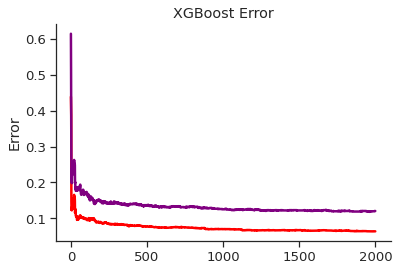

In [15]:
resampling = SMOTE(random_state=18)
test_resampling(resampling,x_train, x_test, y_train, y_test)

#### SMOTE + ENN

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.301639,0.833333,0.575000,0.204444,0.712792,179,34,46,1019
1,Train,0.953204,0.947816,0.965296,0.941411,0.945849,206,119,3310,2593


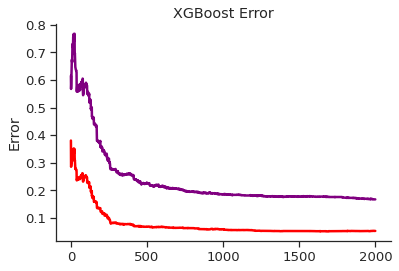

In [16]:
resampling = SMOTEENN(random_state=7)
test_resampling(resampling,x_train, x_test, y_train, y_test)

#### SMOTE + Tomek links

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.209302,0.893584,0.225000,0.195652,0.581615,74,62,18,1124
1,Train,0.935787,0.936035,0.932175,0.939428,0.936035,218,246,3381,3409


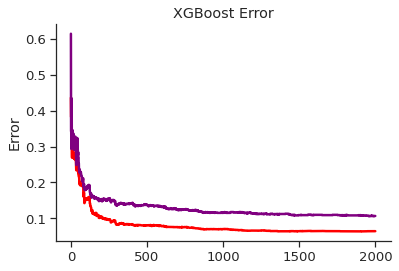

In [17]:
resampling = SMOTETomek(random_state=7)
test_resampling(resampling,x_train, x_test, y_train, y_test)

#### Random oversampler

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.249221,0.811424,0.5,0.165975,0.666110,201,40,40,997
1,Train,0.928499,0.922993,1.0,0.866540,0.922993,564,0,3662,3098


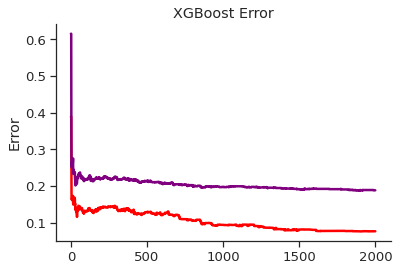

In [18]:
resampling = RandomOverSampler(random_state=7)
test_resampling(resampling,x_train, x_test, y_train, y_test)

#### Random undersampler

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.263473,0.711268,0.82500,0.15677,0.764336,355,14,66,843
1,Train,0.783333,0.769231,0.83432,0.73822,0.769231,50,28,141,119


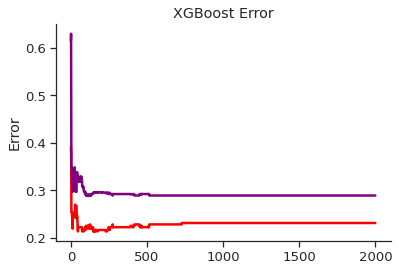

In [19]:
resampling = RandomUnderSampler(random_state=7)
test_resampling(resampling,x_train, x_test, y_train, y_test)

From the results above it is clear that all the algorithms (except for the undersampling one) show qualitatively the same performances. 
* Indeed, in all cases, the $F_1$ score, which is the appropriate metric for imbalanced binary datasets, is greater than 0.9 on the training set and ~0.25 on the test set. By tuning the hyperparameters of these classifiers it is possible to further increase the $F_1$ score on the training set, even to 0.99, but this would result in overfitting since no gain would be obtained on the $F_1$ score on the test set.
* In all cases, the number of false negatives is quite large compared to the number of true positives. This is bad, due to the relatively small number of patients subjected to stroke in the dataset.
* The undersampling algorithm gives a smaller $F_1$ score on the training set. However, in what follows I will show that with an appropriate tuning of the hyperparameters, it is possible to get the same performances of the other resampling techniques.

### 3.1 Hyperparameters tuning with GridSearchCV

In [20]:
def update_pars(new_p,pars):
    for p in new_p.keys():
        pars[p] = new_p[p]

In [21]:
def test_in_range(x_trainf, x_testf, y_trainf, y_testf, pars,param_test):


    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( **pars), 
    param_grid = param_test, scoring='f1',n_jobs=1, cv=5)

    gsearch1.fit(x_trainf,y_trainf)

    print('Best score: ',gsearch1.best_params_)

    update_pars(gsearch1.best_params_,pars_xgb)

    clf_rf = xgb.XGBClassifier(**pars)      
    clr_rf = clf_rf.fit(x_trainf,y_trainf)

    compute_score(y_trainf,y_testf,clr_rf.predict(x_trainf),clr_rf.predict(x_testf))

In [22]:
resampling = RandomUnderSampler(random_state=7)
x_tmp, y_tmp = resampling.fit_resample(x_train, y_train)
x_train_res = pd.DataFrame(x_tmp,columns=df_cols)
y_train_res = pd.Series(y_tmp)

param_test1 = {
 'scale_pos_weight':range(1,10,3),
}

pars_xgb = {'objective':'binary:logistic',
            'random_state':7,
            'scale_pos_weight':1,
            'use_label_encoder':False,
            'eval_metric':'error',
            'learning_rate':0.01,
            'colsample_bytree': 0.05,
            'subsample': 0.8,
            'n_estimators':2000, 
            'reg_alpha': 0.3,
            'n_jobs':1,
            'max_depth':10, 
            'gamma':10
           }

test_in_range(x_train_res, x_test, y_train_res, y_test, pars_xgb, param_test1)

Best score:  {'scale_pos_weight': 1}


,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.263473,0.711268,0.82500,0.15677,0.764336,355,14,66,843
1,Train,0.783333,0.769231,0.83432,0.73822,0.769231,50,28,141,119


In [23]:
param_test1 = {
 'max_depth':range(3,15,2),
 'min_child_weight':range(1,6,2),
}

test_in_range(x_train_res, x_test, y_train_res, y_test, pars_xgb, param_test1)

Best score:  {'max_depth': 3, 'min_child_weight': 1}


,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.263473,0.711268,0.82500,0.15677,0.764336,355,14,66,843
1,Train,0.783333,0.769231,0.83432,0.73822,0.769231,50,28,141,119


In [24]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

test_in_range(x_train_res, x_test, y_train_res, y_test, pars_xgb, param_test1)

Best score:  {'gamma': 0.0}


,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.244726,0.719875,0.725000,0.147208,0.722266,336,22,58,862
1,Train,0.847458,0.840237,0.887574,0.810811,0.840237,35,19,150,134


In [25]:
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
test_in_range(x_train_res, x_test, y_train_res, y_test, pars_xgb, param_test1)

Best score:  {'colsample_bytree': 0.7, 'subsample': 0.6}


,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.242826,0.731612,0.687500,0.147453,0.711029,318,25,55,880
1,Train,0.956012,0.955621,0.964497,0.947674,0.955621,9,6,163,160


## 4. Dimensionality reduction

#### 4.A Univariate analysis
Univariate tests measure the correlation between the selected feature and the target. Each feature is analyzed independently, not taking into account the correlation between different features.    

In [26]:
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)
order_ind = select_feature.scores_.argsort()
print('Score list:', select_feature.scores_[order_ind[::-1]])
print('Feature list:', x_train.columns[order_ind[::-1]])

Score list: [2.53033166e+03 1.11324883e+03 6.87148035e+01 5.52678668e+01
 1.98582479e+01 1.15332567e+01 1.08992056e+01 9.51950985e+00
 7.44049370e+00 8.30693610e-01 7.47453147e-01 6.34413256e-01
 1.27818868e-01 2.53729493e-02 1.85897335e-03]
Feature list: Index(['age', 'avg_glucose_level', 'heart_disease', 'hypertension',
       'work_type_children', 'ever_married_Yes', 'work_type_Self-employed',
       'bmi', 'smoking_status_formerly smoked', 'work_type_Never_worked',
       'Residence_type_Urban', 'smoking_status_smokes', 'work_type_Private',
       'gender_Male', 'smoking_status_never smoked'],
      dtype='object')


The score list above confirms the findings of the [data visualization section](#2.-Data-visualization). In particular, age is the most important feature to consider here, together with the average glucose level. Among the other important variables selected by the univariate algorithm it is interesting to mention the  'ever_married_Yes', that we know is strongly correlated with age, as well as 'work_type_children'. For this reason, before proceeding with the dimensionality reduction it is necessary to employ a multivariate algorithm.

### 4.B Recursive feature elimination (RFE) with random forest

Random forest can be employed in combination with the [feature ranking with recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) algorithm. Due to the strong correlation between features, the expected outcome significantly differs from the output of the univariate algorithm employed in the previous section.

In [27]:
resampling = SMOTEENN(random_state=7)
x_tmp, y_tmp = resampling.fit_resample(x_train, y_train)
x_train_tmp = pd.DataFrame(x_tmp,columns=df_cols)
y_train_tmp = pd.Series(y_tmp)

clf_rf = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train_tmp, y_train_tmp)
print('Selected features:',x_train.columns[rfe.support_])

Selected features: Index(['age', 'avg_glucose_level', 'bmi', 'work_type_Private',
       'smoking_status_never smoked'],
      dtype='object')


As expected, the best features selected by the algorithm do not include the varialbe 'ever_married_Yes', which is strongly correlated with age. Among the five best features the variables 'smoking_status_never smoked' and 'smoking_status_smokes' have been included, which however have a weak correlation with the target. These variables may not give significative additional information to the classifier. Let's test now the XGBoost classifier with SMOTEENN employing the selected features...

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.326154,0.828638,0.662500,0.216327,0.751116,192,27,53,1006
1,Train,0.944800,0.939240,0.963289,0.927007,0.937160,250,121,3175,2560


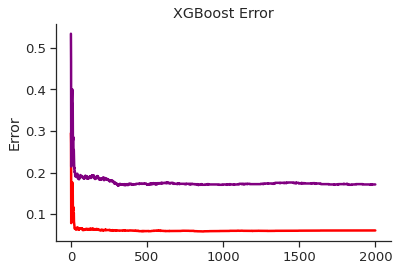

In [28]:
pars_xgb = {'objective':'binary:logistic',
            'random_state':7,
            'scale_pos_weight':1,
            'use_label_encoder':False,
            'eval_metric':'error',
            'learning_rate':0.01,
            'colsample_bytree': 0.05,
            'subsample': 0.8,
            'n_estimators':2000, 
            'reg_alpha': 0.3,
            'n_jobs':1,
            'max_depth':10, 
            'gamma':10
           }

rf_rfe_columns = list(x_train.columns[rfe.support_])
test_resampling(resampling,x_train[rf_rfe_columns], 
                x_test[rf_rfe_columns], y_train, y_test, rf_rfe_columns)

The $F_1$ score on the test set has slightly improved compared to the classification performed including all the available features in [Sec. 3](#3.-Testing-resampling-techniques-with-XGBoost-binary-classifier). However, the number of features has been drastically reduced to 5. In the next section, I am going to test another multivariate feature selection algorithm and compare the results with what obtained here.

### 4.C RFE with Cross Validation (RFECV) with random forest
Below, I am going to the RFE algorithm with cross-validation, employing the random forest classifier. This will allow to crosscheck the best features selected in the previous subsection and to get the optimal number of features.

In [29]:
from sklearn.feature_selection import RFECV

clf_rf = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf, step=1, cv=10,scoring='f1')
rfecv = rfecv.fit(x_train_tmp, y_train_tmp)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 4
Best features : Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status_never smoked'], dtype='object')


The optimal number of features is 3, and they correspond with the ones selected in the previous subsection.

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.327381,0.823161,0.687500,0.214844,0.759860,201,25,55,997
1,Train,0.945075,0.940089,0.961811,0.928911,0.938409,239,124,3123,2573


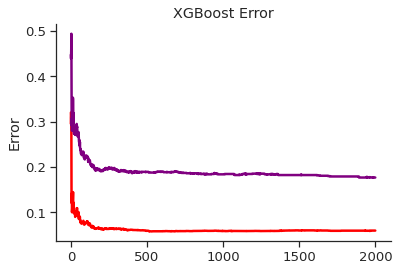

In [30]:
rf_rfecv_columns = list(x_train.columns[rfecv.support_])
test_resampling(resampling,x_train[rf_rfecv_columns], 
                x_test[rf_rfecv_columns], y_train, y_test, rf_rfecv_columns)

The $F_1$ score on the test set remains constant compared to the results of [Sec. 4.C](#4.C-Recursive-feature-elimination-(RFE)-with-random-forest).

## 4.D Principle component analysis (PCA) for feature extraction

In [31]:
pca_stroke = PCA()
principalComponents_stroke = pca_stroke.fit_transform(df_one_hot.drop(['stroke'],axis=1)[df_cols])

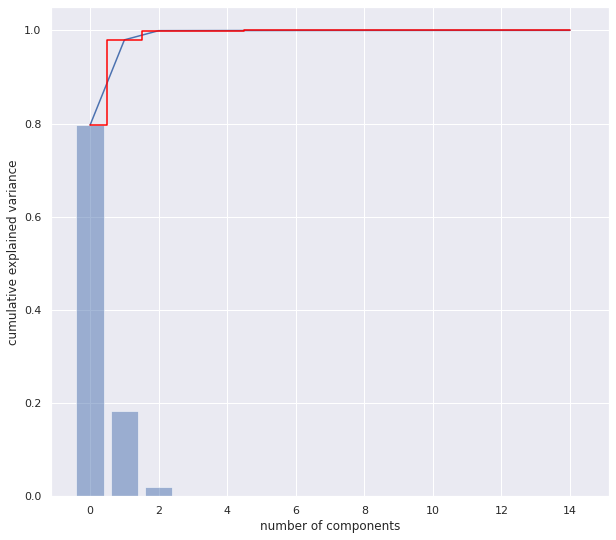

In [32]:
sns.set()
plt.figure(1, figsize=(10, 9))
sns.lineplot(data=np.cumsum(pca_stroke.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

plt.bar(range(0,15), pca_stroke.explained_variance_ratio_,
        alpha=0.5,
        align='center')
plt.step(range(0,15), np.cumsum(pca_stroke.explained_variance_ratio_),
         where='mid',
         color='red')

In [33]:
n_pca = 2
pca_cols = []
for j in range(n_pca):
    pca_cols.append('pca%d'%(j))
principalComp_stroke_df = pd.DataFrame(data = principalComponents_stroke[:,:n_pca],
                                      columns=pca_cols)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(principalComp_stroke_df, df['stroke'], 
                                                    test_size=0.25, random_state=42)

,Dataset,F1,Accuracy,Recall,Precision,ROC AUC,False Positives (T-I),False Negatives (T-II),True Positives,True Negatives
0,Test,0.280193,0.766823,0.725000,0.173653,0.747308,276,22,58,922
1,Train,0.933502,0.930395,0.950331,0.917259,0.929817,233,135,2583,2336


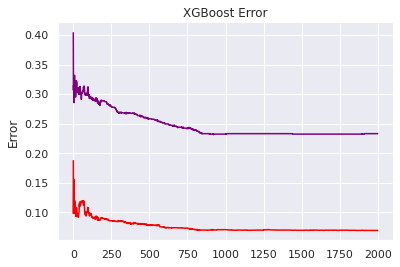

In [35]:
test_resampling(resampling,x_train, 
                x_test, y_train, y_test, pca_cols)